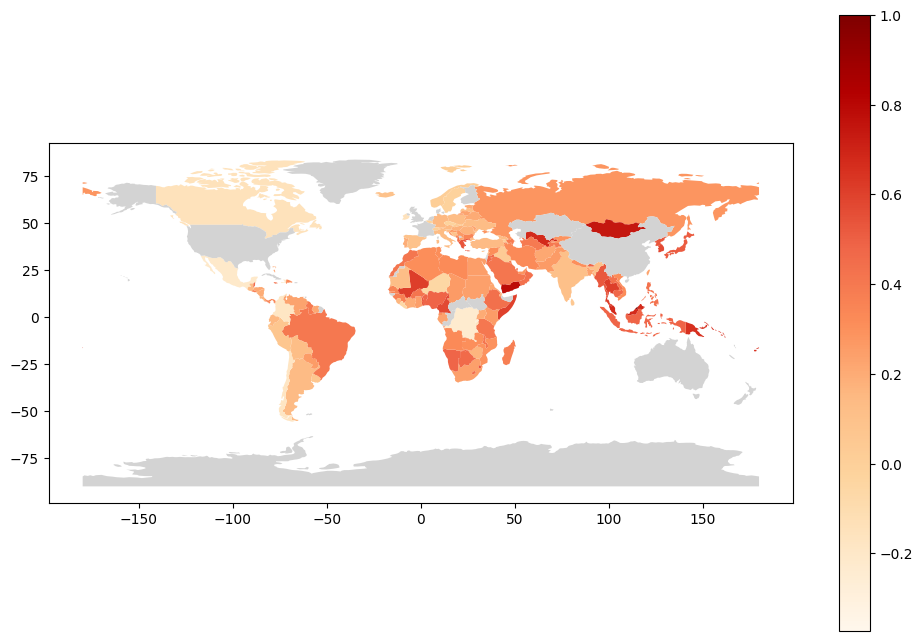

In [53]:
%matplotlib inline

from sklearn import svm
from keras.utils import get_file
import os
import glob
import gensim
import numpy as np
import random
import requests
import geopandas as gpd
from IPython.core.pylabtools import figsize
figsize(12, 8)
import csv

#model downloaded from kaggle
#url as of 27-11-2024: https://www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300?resource=download

path = './datasets/GoogleNews-vectors-negative300.zip'

#unzipping
unzipped = glob.glob('./datasets/extracted/*.bin')[0]
if not unzipped:
    if not os.path.isdir('./datasets/extracted'):
        os.mkdir('./datasets/extracted')
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall('./datasets/extracted')

unzipped = glob.glob('./datasets/extracted/*.bin')[0]

#open model
model = gensim.models.KeyedVectors.load_word2vec_format(unzipped, binary=True)

#open data of countries
countries = list(csv.DictReader(open('../data/countries.csv')))
countries[:10]

#training model
positive = [x['name'] for x in random.sample(countries, 40)]
negative = random.sample(model.index_to_key, 5000)
negative[:4]

labelled = [(p, 1) for p in positive] + [(n, 0) for n in negative]
random.shuffle(labelled)
X = np.asarray([model[w] for w, l in labelled])
y = np.asarray([l for w, l in labelled])
X.shape, y.shape

TRAINING_FRACTION = 0.3
cut_off = int(TRAINING_FRACTION * len(labelled))
clf = svm.SVC(kernel='linear')
clf.fit(X[:cut_off], y[:cut_off])

res = clf.predict(X[cut_off:])

missed = [country for (pred, truth, country) in 
 zip(res, y[cut_off:], labelled[cut_off:]) if pred != truth]

100 - 100 * float(len(missed)) / len(res), missed

all_predictions = clf.predict(model.vectors)

res = []
for word, pred in zip(model.index_to_key, all_predictions):
    if pred:
        res.append(word)
        if len(res) == 150:
            break
random.sample(res, 10)

def rank_countries(term, topn=10, field='name'):
    if not term in model:
        return []
    vec = model[term]
    dists = np.dot(country_vecs, vec)
    return [(countries[idx][field], float(dists[idx])) 
            for idx in reversed(np.argsort(dists)[-topn:])]

#valid url as of 03-12-2024
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip");
world.head()
def map_term(term):
    d = {k.upper(): v for k, v in rank_countries(term, topn=0, field='cc3')}
    world[term] = world['SOV_A3'].map(d)
    world[term] /= world[term].max()
    world.plot(world[term],missing_kwds = dict(color = "lightgrey"),legend=True,cmap='OrRd')
map_term('karate')